In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Directory path
directory = "aex_data/"

# List files and directories in the directory
files_and_directories = os.listdir(directory)

# Print the list
print("Files and directories in", directory, ":")
for item in files_and_directories:
    print(item)


Files and directories in aex_data/ :
.ipynb_checkpoints
ABN_data_2015-11-20_2024-04-11.csv
ABN_data_2022-01-01_2022-12-31.csv
ADYEN_data_2018-06-13_2024-04-11.csv
ADYEN_data_2022-01-01_2022-12-31.csv
AD_data_2008-10-24_2024-04-11.csv
AD_data_2022-01-01_2022-12-31.csv
AGN_data_1995-03-27_2024-04-11.csv
AGN_data_2022-01-01_2022-12-31.csv
AKZA_data_1995-03-27_2024-04-11.csv
AKZA_data_2022-01-01_2022-12-31.csv
ASML_data_1998-07-20_2024-04-11.csv
ASML_data_2022-01-01_2022-12-31.csv
ASM_data_1999-01-06_2024-04-11.csv
ASM_data_2022-01-01_2022-12-31.csv
ASRNL_data_2016-06-10_2024-04-11.csv
ASRNL_data_2022-01-01_2022-12-31.csv
BESI_data_1998-07-20_2024-04-11.csv
BESI_data_2022-01-01_2022-12-31.csv
HEIA_data_1995-03-27_2024-04-11.csv
HEIA_data_2022-01-01_2022-12-31.csv
IMCD_data_2014-06-27_2024-04-11.csv
IMCD_data_2022-01-01_2022-12-31.csv
INGA_data_1995-03-27_2024-04-11.csv
INGA_data_2022-01-01_2022-12-31.csv
KPN_data_1995-03-27_2024-04-11.csv
KPN_data_2022-01-01_2022-12-31.csv
MT_data_2005-07-

In [3]:
df_ABN = pd.read_csv("aex_data/ABN_data_2015-11-20_2024-04-11.csv")

In [4]:
df_ABN

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-20,18.180000,18.430000,18.000000,18.350000,11.638738,38392898
1,2015-11-23,18.450001,18.700001,18.215000,18.610001,11.803647,3352514
2,2015-11-24,18.700001,18.799999,18.370001,18.799999,11.924154,4871901
3,2015-11-25,18.850000,19.500000,18.770000,19.450001,12.336428,4802607
4,2015-11-26,19.480000,19.670000,19.410000,19.430000,12.323741,1648481
...,...,...,...,...,...,...,...
2143,2024-04-05,16.250000,16.480000,16.230000,16.360001,16.360001,2750493
2144,2024-04-08,16.395000,16.504999,16.290001,16.430000,16.430000,2483292
2145,2024-04-09,16.415001,16.490000,16.235001,16.260000,16.260000,2267871
2146,2024-04-10,16.395000,16.580000,16.305000,16.385000,16.385000,3472390


- Trading Days: Stock markets are not open on weekends and holidays, so there are typically fewer than 365 trading days in a year. In 2022, for example, there were approximately 252 trading days on the Amsterdam Stock Exchange.

- Data Availability: Sometimes data providers like Yahoo Finance may not have data available for all trading days, especially for older data or for less liquid stocks.

- Corporate Actions: There might be corporate actions such as stock splits, dividends, or other adjustments that could affect the number of rows in the dataset. These actions can lead to gaps in the data.

- Data Quality: Occasionally, there may be errors or missing data in the dataset, leading to fewer rows than expected.

In [5]:
class stockPredictor:
    def __init__(self, stock_data):
        self.stock_data = stock_data
        self.stock_data_dateIndexed = stock_data
        self.stock_data_dateIndexed.index = pd.to_datetime(stock_data["Date"], format='%Y-%m-%d')
        self.start_date = stock_data.index.min()
        self.end_date = stock_data.index.max()
        self.decomposition = None
        
    def describe_stock_data(self):
        print(self.stock_data.head(3))
        print(self.stock_data.shape)
        print(self.stock_data.describe())
        print(self.stock_data.dtypes)
        print(self.stock_data.dtypes.unique())
    
    def describe_columns(self):
        print("""
        Open - Opening price of the stock at the beginning of the trading day
        High - Highest value that the stock reached on that day
        Low - Lowest value that the stock reached on that day
        Close - Closing value that the stock reached on that day
        Adj Close - The adjusted closing price is the closing price of the stock adjusted
        to include any corporate actions that occurred before the next trading day's open.
        Volume - Number of stocks traded that day
        """)
    
    def handleMissingValues(self):
        self.stock_data_dateIndexed = self.stock_data_dateIndexed.reindex(pd.date_range(start=self.stock_data_dateIndexed.index.min(), end=self.stock_data_dateIndexed.index.max(), freq='D'))

        # Handle missing values (replace NaN with appropriate method)
        self.stock_data_dateIndexed = self.stock_data_dateIndexed.fillna(method='bfill')  # Forward fill missing values

        # Set the frequency of the index
        self.stock_data_dateIndexed.index.freq = 'D'  # Set the frequency to daily

    def timeSeriesSeasonality(self):
        stock_dates = self.stock_data_dateIndexed["Date"]
        stock_prices_close = self.stock_data_dateIndexed["Close"]
        
        # stock_prices_close_numericalindices will keep the original index
        #stock_prices_close_numericalindices = stock_prices_close.copy()

        # Convert the index to a DatetimeIndex for stock_prices_close_dateindices
        #stock_prices_close_dateindices = stock_prices_close.copy()
        #stock_prices_close_dateindices.index = pd.to_datetime(stock_dates, format='%Y-%m-%d')
        #print(stock_prices_close)
        #print(stock_prices_close_numericalindices)
        
        # Plot the time series data
        plt.figure(figsize=(10, 6))
        plt.plot(stock_prices_close)
        plt.title('Stock Prices Over Time')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()

        # ACF plot
        plt.figure(figsize=(10, 6))
        sm.graphics.tsa.plot_acf(stock_prices_close, lags=20)
        plt.title('Autocorrelation Function (ACF) Plot')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()

        # PACF plot
        plt.figure(figsize=(10, 6))
        sm.graphics.tsa.plot_pacf(stock_prices_close, lags=20)
        plt.title('Partial Autocorrelation Function (PACF) Plot')
        plt.xlabel('Lag')
        plt.ylabel('Partial Autocorrelation')
        plt.show()

        # Seasonal decomposition
        decomposition = sm.tsa.seasonal_decompose(stock_prices_close, model='additive')
        self.decomposition = decomposition
        print(type(decomposition))
        fig, axes = plt.subplots(4, 1, figsize=(10, 8))
        axes[0].plot(stock_prices_close, label='Original')
        axes[0].legend(loc='upper left')
        axes[1].plot(decomposition.trend, label='Trend')
        axes[1].legend(loc='upper left')
        axes[2].plot(decomposition.seasonal, label='Seasonal')
        axes[2].legend(loc='upper left')
        axes[3].plot(decomposition.resid, label='Residual')
        axes[3].legend(loc='upper left')
        plt.tight_layout()
        plt.show()


    def timeSeriesArima(self):
        # Load stock market data 

        # Assuming 'Close' prices are in a column named 'Close'
        # For simplicity, we'll work with a single stock's closing prices

        stock_prices_close = self.stock_data["Close"]

        # Fit ARIMA model
        model = ARIMA(stock_prices_close, order=(1, 1, 1))  # Example order, replace with appropriate values
        model_fit = model.fit()

        # Summary of the model
        print(model_fit.summary())

        # Forecast future values
        forecast = model_fit.forecast(steps=5)  # Example steps for forecasting 5 future time points
        print("Forecasted values:", forecast)
        
    def data_tsa_visualisation(self):
        stock_dates = self.stock_data_dateIndexed["Date"]
        stock_prices_close = self.stock_data_dateIndexed["Close"]
        
        # Plotting histogram of stock prices
        plt.hist(stock_prices_close, bins=20, color='blue', edgecolor='black')
        plt.title('Distribution of Stock Prices')
        plt.xlabel('Price')
        plt.ylabel('Frequency')
        plt.show()

        # Plotting time series of stock prices
        plt.figure(figsize=(10, 6))
        plt.plot(stock_dates.values, stock_prices_close.values, color='green')
        plt.title('Stock Prices Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()
        
        # Calculate correlation matrix
        correlation_matrix = self.stock_data_dateIndexed.select_dtypes(include='number').corr()

        # Plotting heatmap of correlations
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap')
        plt.show()
        
    def residuals_analysis(self):

        # Assuming you already have the decomposed components stored in `decomposition`
        # Access the residuals from the decomposition
        residuals = self.decomposition.resid
        print(f"Total null values in the Dataframe - residuals: {residuals.isnull().sum().sum()}")
        if residuals.isnull().sum().sum() > 0:
            residuals = residuals.dropna(axis=0, how='any')
        
        if residuals.isin([np.inf, -np.inf]).any().any():
            print("DataFrame contains infinite values")
        else:
            print("DataFrame contains -NO- infinite values")

        # Plotting the residuals
        plt.figure(figsize=(10, 6))
        plt.plot(residuals)
        plt.title('Residuals of Time Series Decomposition')
        plt.xlabel('Time')
        plt.ylabel('Residual')
        plt.show()

        # Autocorrelation plot of residuals
        plt.figure(figsize=(10, 6))
        sm.graphics.tsa.plot_acf(residuals, lags=20)
        plt.title('Autocorrelation Function (ACF) of Residuals')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()

        # Histogram of residuals
        plt.figure(figsize=(10, 6))
        plt.hist(residuals, bins=20, density=True)
        plt.title('Histogram of Residuals')
        plt.xlabel('Residual')
        plt.ylabel('Density')
        plt.show()

        # Perform statistical tests for stationarity or autocorrelation on residuals
        # For example:
        # Perform Augmented Dickey-Fuller test for stationarity
        adf_test_result = sm.tsa.stattools.adfuller(residuals)
        print("ADF test statistic:", adf_test_result[0])
        print("p-value:", adf_test_result[1])
        print("Critical values:", adf_test_result[4])






In [6]:
sp_ABN = stockPredictor(df_ABN)
sp_ABN.describe_stock_data()

                  Date       Open       High        Low      Close  Adj Close  \
Date                                                                            
2015-11-20  2015-11-20  18.180000  18.430000  18.000000  18.350000  11.638738   
2015-11-23  2015-11-23  18.450001  18.700001  18.215000  18.610001  11.803647   
2015-11-24  2015-11-24  18.700001  18.799999  18.370001  18.799999  11.924154   

              Volume  
Date                  
2015-11-20  38392898  
2015-11-23   3352514  
2015-11-24   4871901  
(2148, 7)
              Open         High          Low        Close    Adj Close  \
count  2148.000000  2148.000000  2148.000000  2148.000000  2148.000000   
mean     16.268446    16.444955    16.073203    16.256456    12.485520   
std       5.615270     5.629021     5.591854     5.611438     3.512673   
min       5.976000     6.162000     5.680000     5.842000     4.667253   
25%      11.601500    11.772250    11.509500    11.629000     9.682593   
50%      15.865000    16.

In [7]:
sp_ABN.describe_columns()


        Open - Opening price of the stock at the beginning of the trading day
        High - Highest value that the stock reached on that day
        Low - Lowest value that the stock reached on that day
        Close - Closing value that the stock reached on that day
        Adj Close - The adjusted closing price is the closing price of the stock adjusted
        to include any corporate actions that occurred before the next trading day's open.
        Volume - Number of stocks traded that day
        


In [8]:
sp_ABN.handleMissingValues()

In [9]:
sp_ABN.stock_data_dateIndexed

,Date,Open,High,Low,Close,Adj Close,Volume
2015-11-20,2015-11-20,18.180000,18.430000,18.000000,18.350000,11.638738,38392898.0
2015-11-21,2015-11-23,18.450001,18.700001,18.215000,18.610001,11.803647,3352514.0
2015-11-22,2015-11-23,18.450001,18.700001,18.215000,18.610001,11.803647,3352514.0
2015-11-23,2015-11-23,18.450001,18.700001,18.215000,18.610001,11.803647,3352514.0
2015-11-24,2015-11-24,18.700001,18.799999,18.370001,18.799999,11.924154,4871901.0
...,...,...,...,...,...,...,...
2024-04-07,2024-04-08,16.395000,16.504999,16.290001,16.430000,16.430000,2483292.0
2024-04-08,2024-04-08,16.395000,16.504999,16.290001,16.430000,16.430000,2483292.0
2024-04-09,2024-04-09,16.415001,16.490000,16.235001,16.260000,16.260000,2267871.0
2024-04-10,2024-04-10,16.395000,16.580000,16.305000,16.385000,16.385000,3472390.0


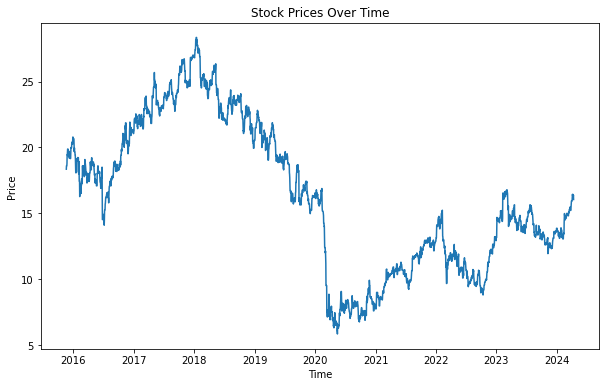

<Figure size 720x432 with 0 Axes>

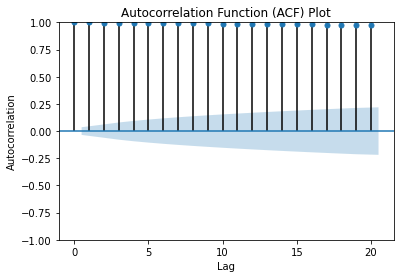

<Figure size 720x432 with 0 Axes>

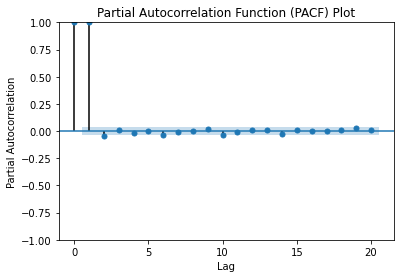

<class 'statsmodels.tsa.seasonal.DecomposeResult'>


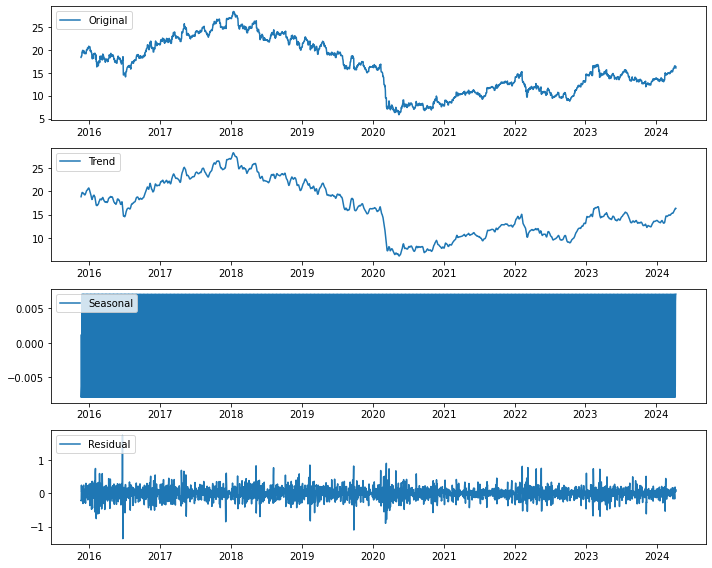

In [10]:
sp_ABN.timeSeriesSeasonality()

In [11]:
sp_ABN.timeSeriesArima()

C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2148
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -485.693
Date:                Fri, 12 Apr 2024   AIC                            977.385
Time:                        18:26:34   BIC                            994.401
Sample:                             0   HQIC                           983.611
                               - 2148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6032      0.163     -3.693      0.000      -0.923      -0.283
ma.L1          0.6581      0.157      4.192      0.000       0.350       0.966
sigma2         0.0920      0.001     64.594      0.0

C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- AIC (Akaike Information Criterion): A measure of the relative quality of a statistical model, with a lower AIC indicating a better-fitting model. It's used for model selection among a set of candidate models.

- BIC (Bayesian Information Criterion): Similar to AIC, but it penalizes the number of parameters more heavily, favoring simpler models.

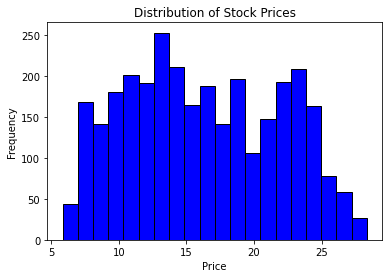

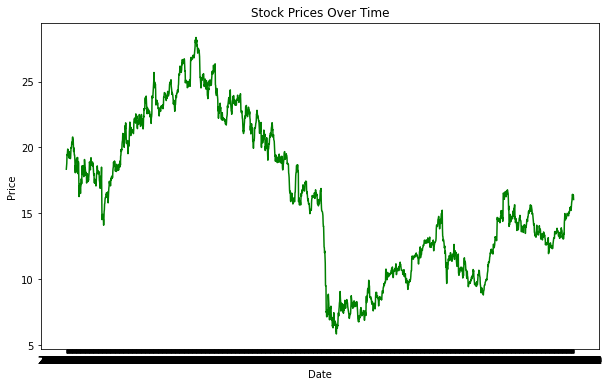

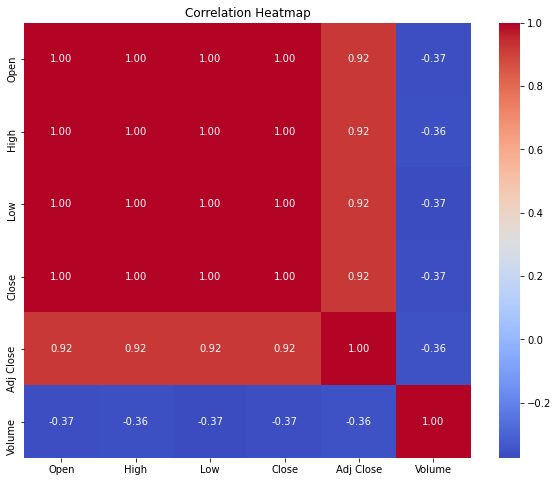

In [12]:
#sp_ABN.data_tsa_visualisation()

Total null values in the Dataframe - residuals: 6
DataFrame contains -NO- infinite values


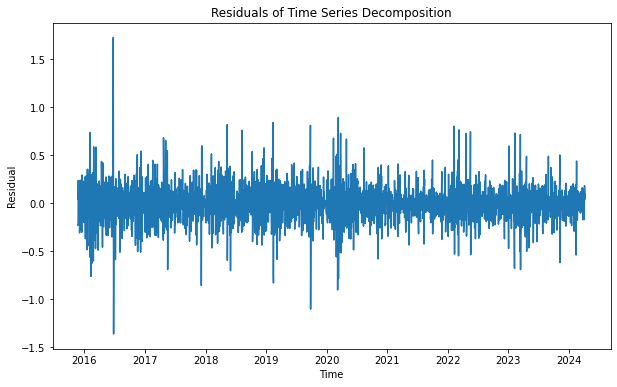

<Figure size 720x432 with 0 Axes>

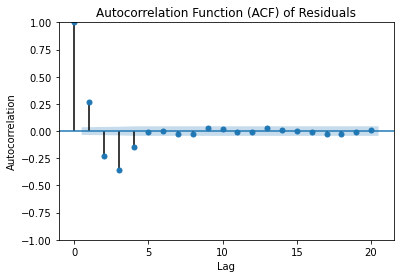

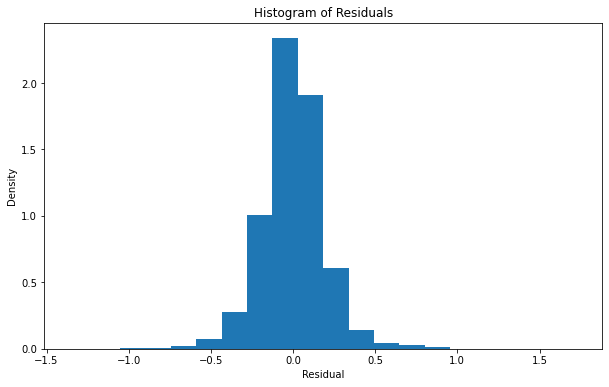

ADF test statistic: -19.7804250068752
p-value: 0.0
Critical values: {'1%': -3.432503613730928, '5%': -2.8624915293046693, '10%': -2.5672765233028003}


In [13]:
sp_ABN.residuals_analysis()